# 3115 - Lab Programming Machine Learning

## Lab Exercise 9

## Yuvaraj Prem Kumar, 303384

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

In [2]:
# Importing sklearn libraries
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.datasets import dump_svmlight_file, load_svmlight_file
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, log_loss
from sklearn.metrics import plot_confusion_matrix, f1_score, recall_score, precision_score, ConfusionMatrixDisplay

# Exercise 1: Spam Filter using SVM

SVM builds a classifier by searching for a separating hyperplane which is optimal and maximises the margin that separates the categories [1]. The core of an SVM is a quadratic programming problem (QP), separating support vectors from the rest of the training data [2]. In this case the categories are "spam" and "ham". The advantage of SVM is its robustness when the number of dimensions is greater than the number of samples.

Tuning the following parameters improve the performance of the algorithm [2]:
* Kernel: A similarity function. It’s a way of computing the dot product of two vectors in possibly a high dimensional feature space using data transformations based on some provided constraints into a more complex space. Kernel functions are sometimes called “generalized dot product”. For this exercise, we focus on "linear" and "rbf"
* Gamma: Kernel coefficient for "rbf" (in this case). However too high value of gamma will try to exactly fit as per training data set and cause over-fitting.
* C: Trade-off training error vs. model complexity. A small value of C will increase the number of training errors, while a large C will lead to a behaviour similar to a hard-margin SVM.

## Part A:  Build a spam filter using a pre-processed dataset

We are using "libsvm" library to solve the SVM problem. There some basic steps for fitting the model to learn the support vectors and best "C" which is the cost or regularization parameter. As for kernel, it is left as the default which is Radial Basis Function (rbf), and by extension the gamma parameter will also be left to its default. The steps are:
1. Initialize the model parameters.
2. Fit the model via svm_problem on training set.
3. Make predictions on testing set.
4. Evaluate the model using the classification metrics.

For classification metrics, the main idea is that its much worse to mis-classify non-spam email as spam, hence we do not want to have false positives [4].

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
D3 = pd.read_csv('/content/drive/My Drive/spambase.data', header = None, index_col=False)
D3.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


We can plot the pie-chart of the data to see the distribution of "Ham" vs "Spam"

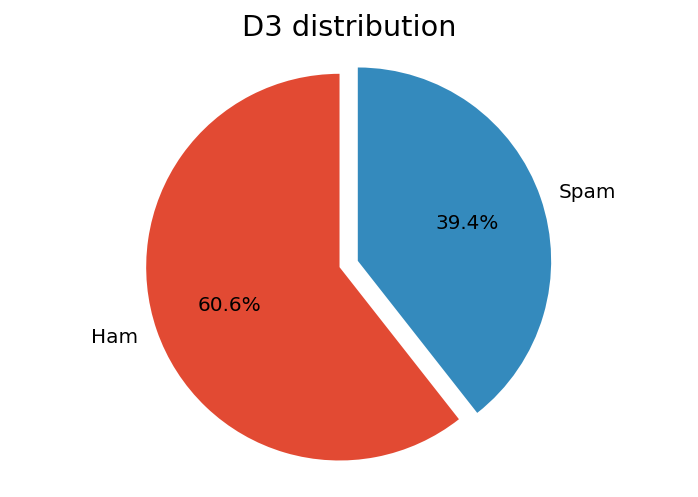

In [6]:
y = D3.iloc[:,-1]
D3_pie = pd.value_counts(y, sort= True)
D3_pie.plot(kind = 'pie', labels=['Ham','Spam'], explode = (0, 0.1), autopct='%1.1f%%', startangle=90)
plt.title('D3 distribution')
plt.axis('equal')
plt.ylabel('')
plt.show()

In [0]:
X = D3.iloc[:,:-1]                   
y = D3.iloc[:,-1]                  # Last column is the target

# Export the data into libsvm format
dump_svmlight_file(X, y, 'spam.dat', zero_based=True, multilabel=False)

# Reload the sparse data
df = load_svmlight_file("spam.dat")

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df[0], df[1], test_size=0.30, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3220, 57), (1381, 57), (3220,), (1381,))

In [10]:
!git clone https://github.com/cjlin1/libsvm
%cd libsvm/
!make && make install
%cd /content/libsvm/python/
!make
import sys
sys.path.append('/content/libsvm/python')
%cd /content

Cloning into 'libsvm'...
remote: Enumerating objects: 3768, done.
remote: Total 3768 (delta 0), reused 0 (delta 0), pack-reused 3768
Receiving objects: 100% (3768/3768), 7.24 MiB | 4.89 MiB/s, done.
Resolving deltas: 100% (2059/2059), done.
/content/libsvm
g++ -Wall -Wconversion -O3 -fPIC -c svm.cpp
g++ -Wall -Wconversion -O3 -fPIC svm-train.c svm.o -o svm-train -lm
g++ -Wall -Wconversion -O3 -fPIC svm-predict.c svm.o -o svm-predict -lm
g++ -Wall -Wconversion -O3 -fPIC svm-scale.c -o svm-scale
make: *** No rule to make target 'install'.  Stop.
/content/libsvm/python
make -C .. lib
make[1]: Entering directory '/content/libsvm'
if [ "Linux" = "Darwin" ]; then \
	SHARED_LIB_FLAG="-dynamiclib -Wl,-install_name,libsvm.so.2"; \
else \
	SHARED_LIB_FLAG="-shared -Wl,-soname,libsvm.so.2"; \
fi; \
g++ ${SHARED_LIB_FLAG} svm.o -o libsvm.so.2
make[1]: Leaving directory '/content/libsvm'
/content


In [0]:
from svmutil import *

In [0]:
c_list = np.arange(0.1, 100, 0.5)
best_model = None
best_MSE = 0
accuracy_hist, mse_hist, f1_hist = [], [], []

problem  = svm_problem(y_train, X_train)

for c in c_list:
    param = svm_parameter('-c '+str(c))
    model = svm_train(problem, param,'-q')
    labels, accuracy, value = svm_predict(y_test, X_test, model,'-q')
    
    f1_hist.append(f1_score(y_test, labels))
    accuracy_hist.append(accuracy[0])
    mse_hist.append(accuracy[1])
    
    if best_model == None or best_MSE > accuracy[1]: 
        best_model = model
        best_MSE = accuracy[1]

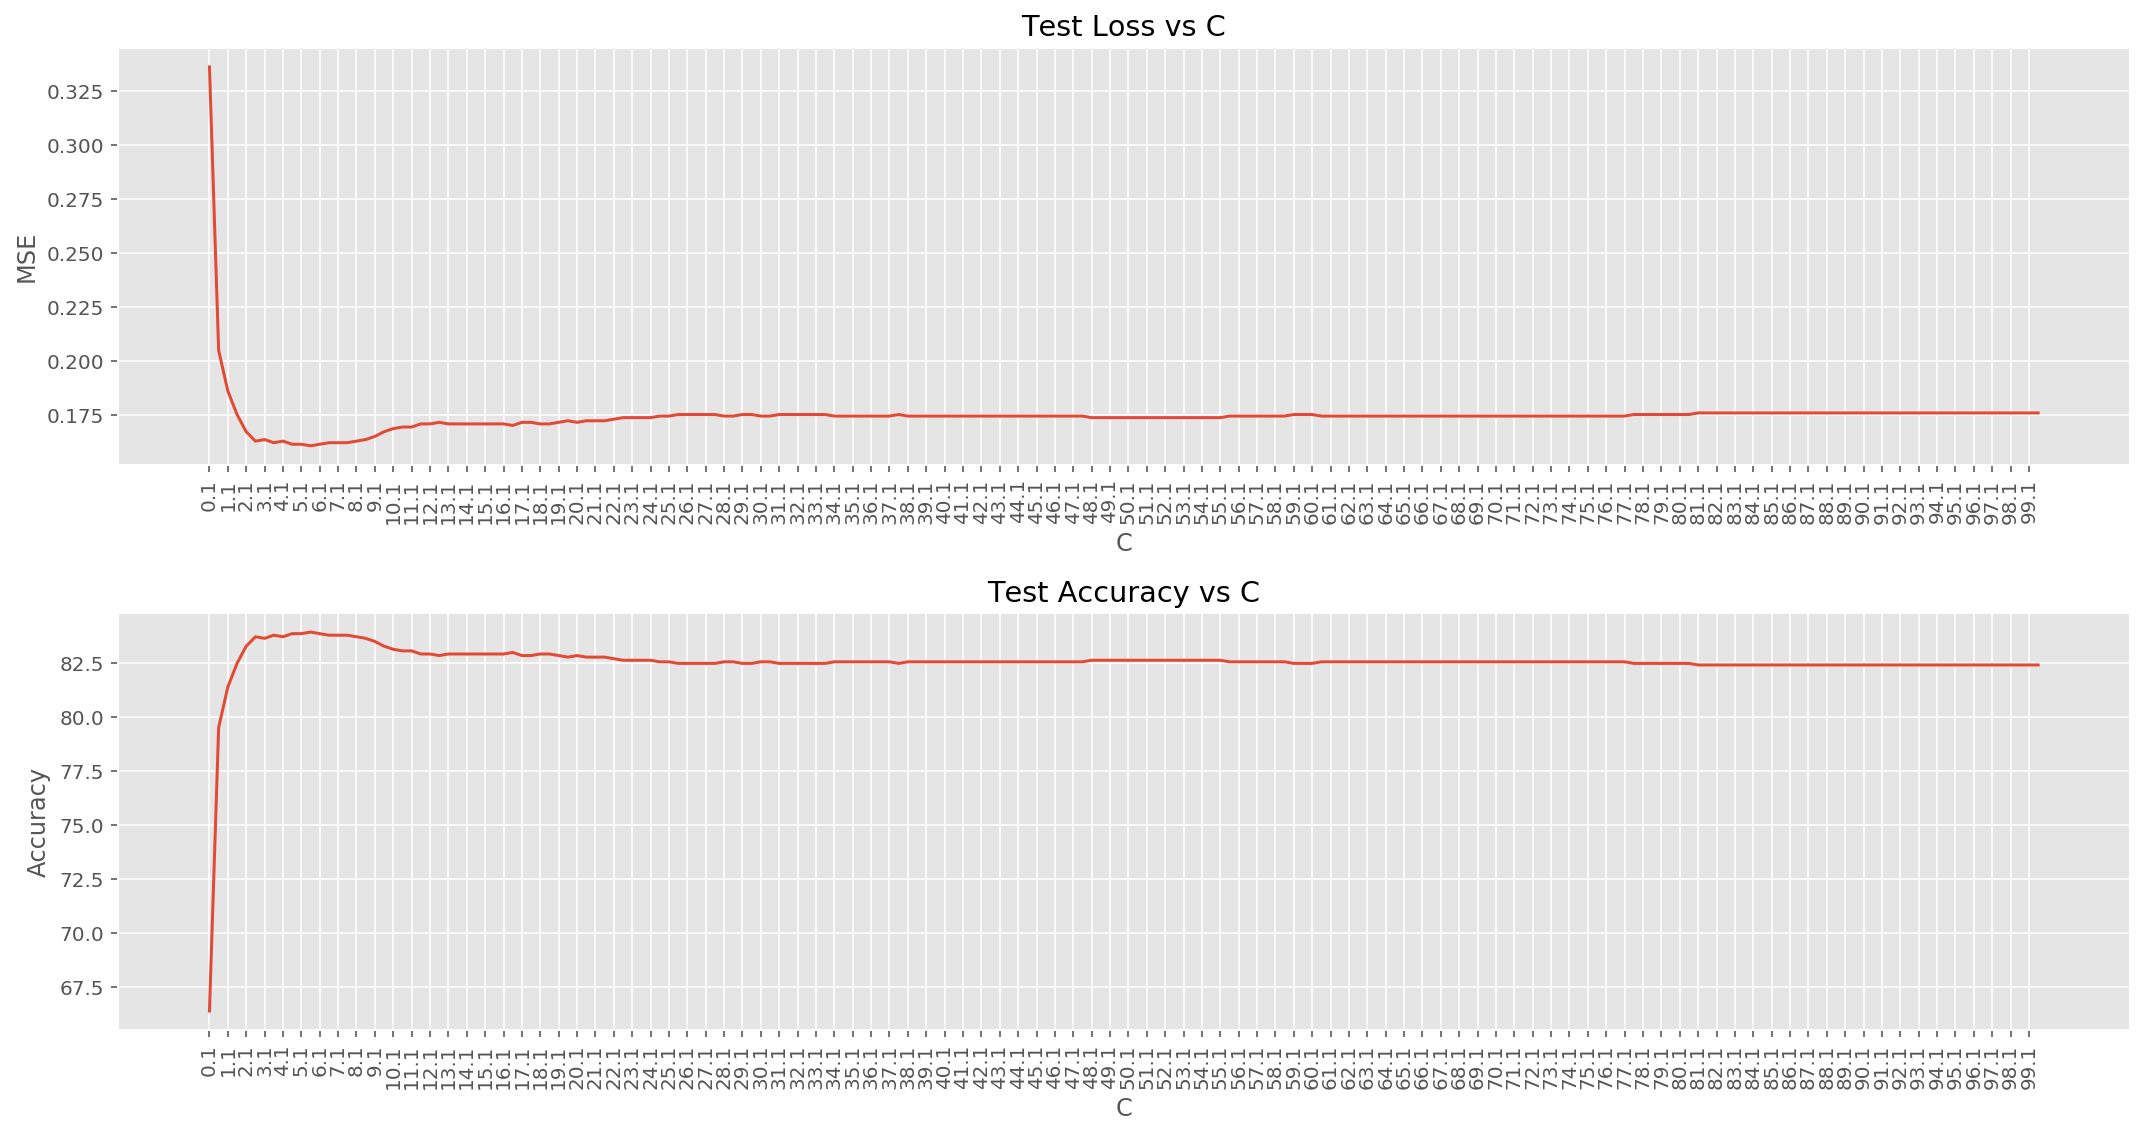

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
ax[0].plot(c_list, mse_hist)
ax[0].set_xticks(np.arange(0.1, 100, 1))
ax[0].set_xticklabels(np.arange(0.1, 100, 1),rotation=90)
ax[0].set_xlabel('C')
ax[0].set_ylabel('MSE')
ax[0].set_title("Test Loss vs C")

ax[1].plot(c_list, accuracy_hist)
ax[1].set_xticks(np.arange(0.1, 100, 1))
ax[1].set_xticklabels(np.arange(0.1, 100, 1),rotation=90)
ax[1].set_xlabel('C')
ax[1].set_ylabel('Accuracy')
ax[1].set_title("Test Accuracy vs C")
plt.tight_layout()
plt.show()

In [0]:
print("Optimal value of 'C':", best_model.param.C)
labels, accuracy, value = svm_predict(y_test, X_test, best_model)

Optimal value of 'C': 5.6
Accuracy = 83.9247% (1159/1381) (classification)


In [0]:
cm = confusion_matrix(y_test, labels)
df_cm = pd.DataFrame(data = cm, columns = ['Predicted: 0', 'Predicted: 1'], index = ['Actual: 0', 'Actual: 1'])
df_cm

,Predicted: 0,Predicted: 1
Actual: 0,680,124
Actual: 1,98,479


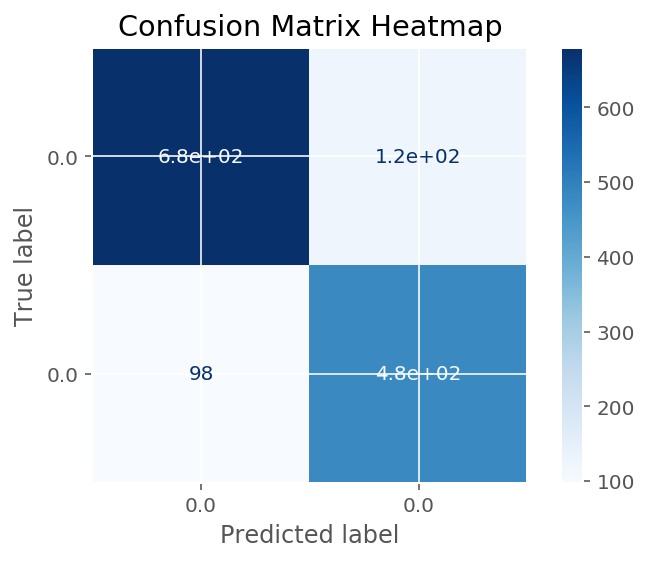

In [0]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp = disp.plot(include_values=[0,1], cmap=plt.cm.Blues)
plt.title('Confusion Matrix Heatmap')
plt.show()

In [0]:
Basically using the libsvm model, the results are not that great. It achieved a True Positive and True Negative of 680 and 479 respectively, but it has a False Positive and False Negative of 124 and 98, meaning there are many emails which have been classifed wrongly.

## Part B: Pre-processed a dataset and learn SVM

In [3]:
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

For this part we are using the unprocessed dataset D2 from [5]. There are some prepocessing steps to be done:
* Encode target column ham/spam to binary [0, 1]
* Removal of stop words using sklearn.feature_extraction
* Streamlining the grid-search using sklearn.pipeline

From [6], the recommendation is to not use the built-in stopwards 'english' as its too basic, in favour of more personalized stopwards list. However, for this exercise using the basic list should be sufficient. We can investigate the data firstly to see its formatting and properties [4].

In [4]:
D2 = pd.read_csv('SMSSpamCollection', sep='\t', header=None)
D2.head(5)

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


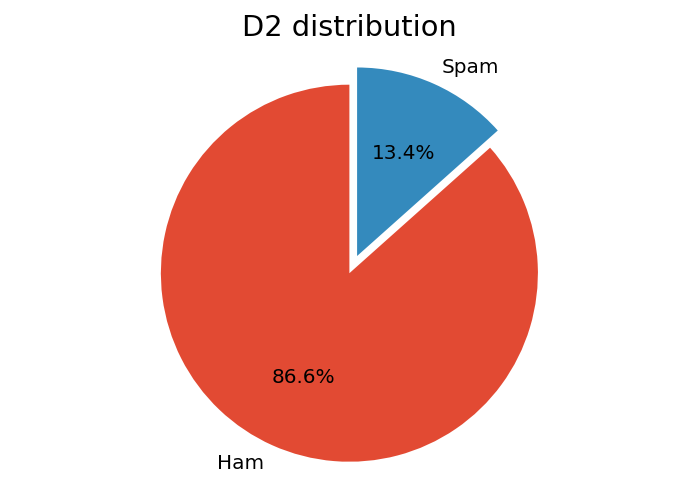

In [5]:
D2_pie = pd.value_counts(D2[0], sort= True)
D2_pie.plot(kind = 'pie', labels=['Ham','Spam'], explode = (0, 0.1), autopct='%1.1f%%', startangle=90)
plt.title('D2 distribution')
plt.axis('equal')
plt.ylabel('')
plt.show()

In [6]:
count1 = Counter(" ".join(D2[D2[0]=='ham'][1]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(D2[D2[0]=='spam'][1]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})
df1.head()

,words in non-spam,count
0,to,1538
1,you,1462
2,I,1439
3,the,1029
4,a,977


In [7]:
df2.head()

,words in spam,count_
0,to,607
1,a,360
2,your,187
3,call,185
4,or,185


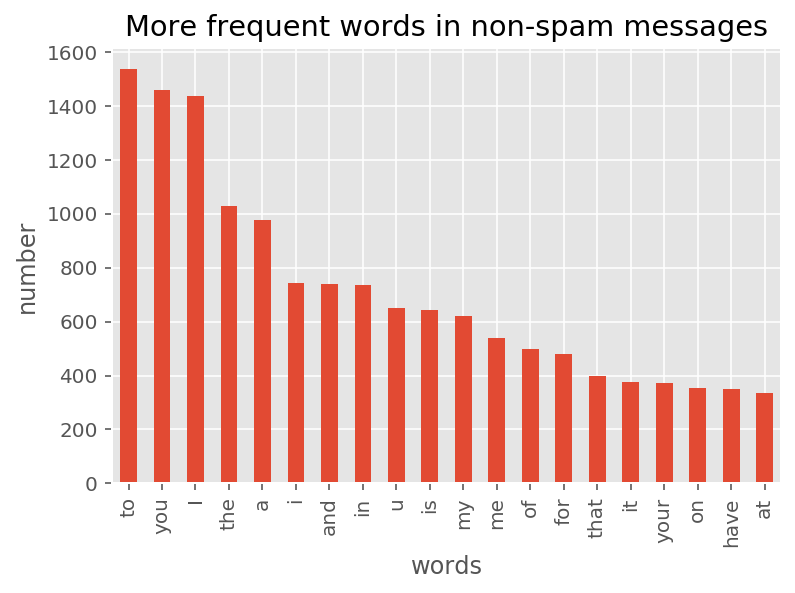

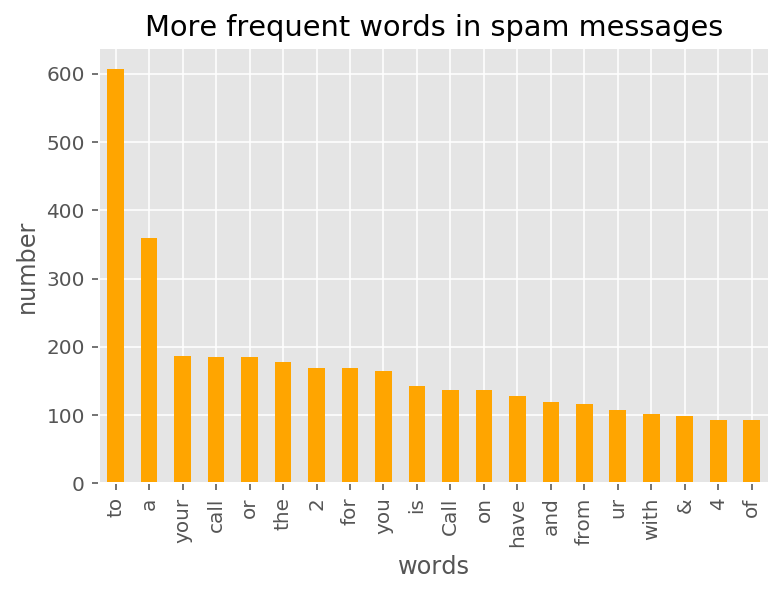

In [8]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')

plt.show()

In [9]:
D2[0] = D2[0].replace(['ham','spam'],[0,1])
D2.head(5)

,0,1
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
X_train, X_test, y_train, y_test = train_test_split(D2[1], D2[0], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4457,), (1115,), (4457,), (1115,))

Now that we have preprocessed the data, we can start to train it on the SVM model. The steps are:
* Using TFIDF vectorizer for stopwords removal
* Initialize a range of hyperparameters [C, gamma, kernal type] for SVM classifier
* Run it through a Pipeline to loop through those hyperparameter [7]
* Make predictions on test set, and compute the classification metrics via sklearn.metrics

In [11]:
svc_c_p = Pipeline([
    ("vectorizer", TfidfVectorizer(stop_words = 'english', lowercase = True)),
    ("classifier", svm.SVC())])

#Define the parameter grid to be explored
param_grid = [{"classifier__C" :  np.arange(0.1, 100, 5), "classifier__kernel" : ['linear','rbf']}]
svc_grid = GridSearchCV(svc_c_p, cv = 5, n_jobs = 5, param_grid = param_grid[0], verbose = 1, refit = True)
svc_grid.fit(X_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   17.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:  1.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                    

In [12]:
svc_grid.best_params_

{'classifier__C': 5.1, 'classifier__kernel': 'linear'}

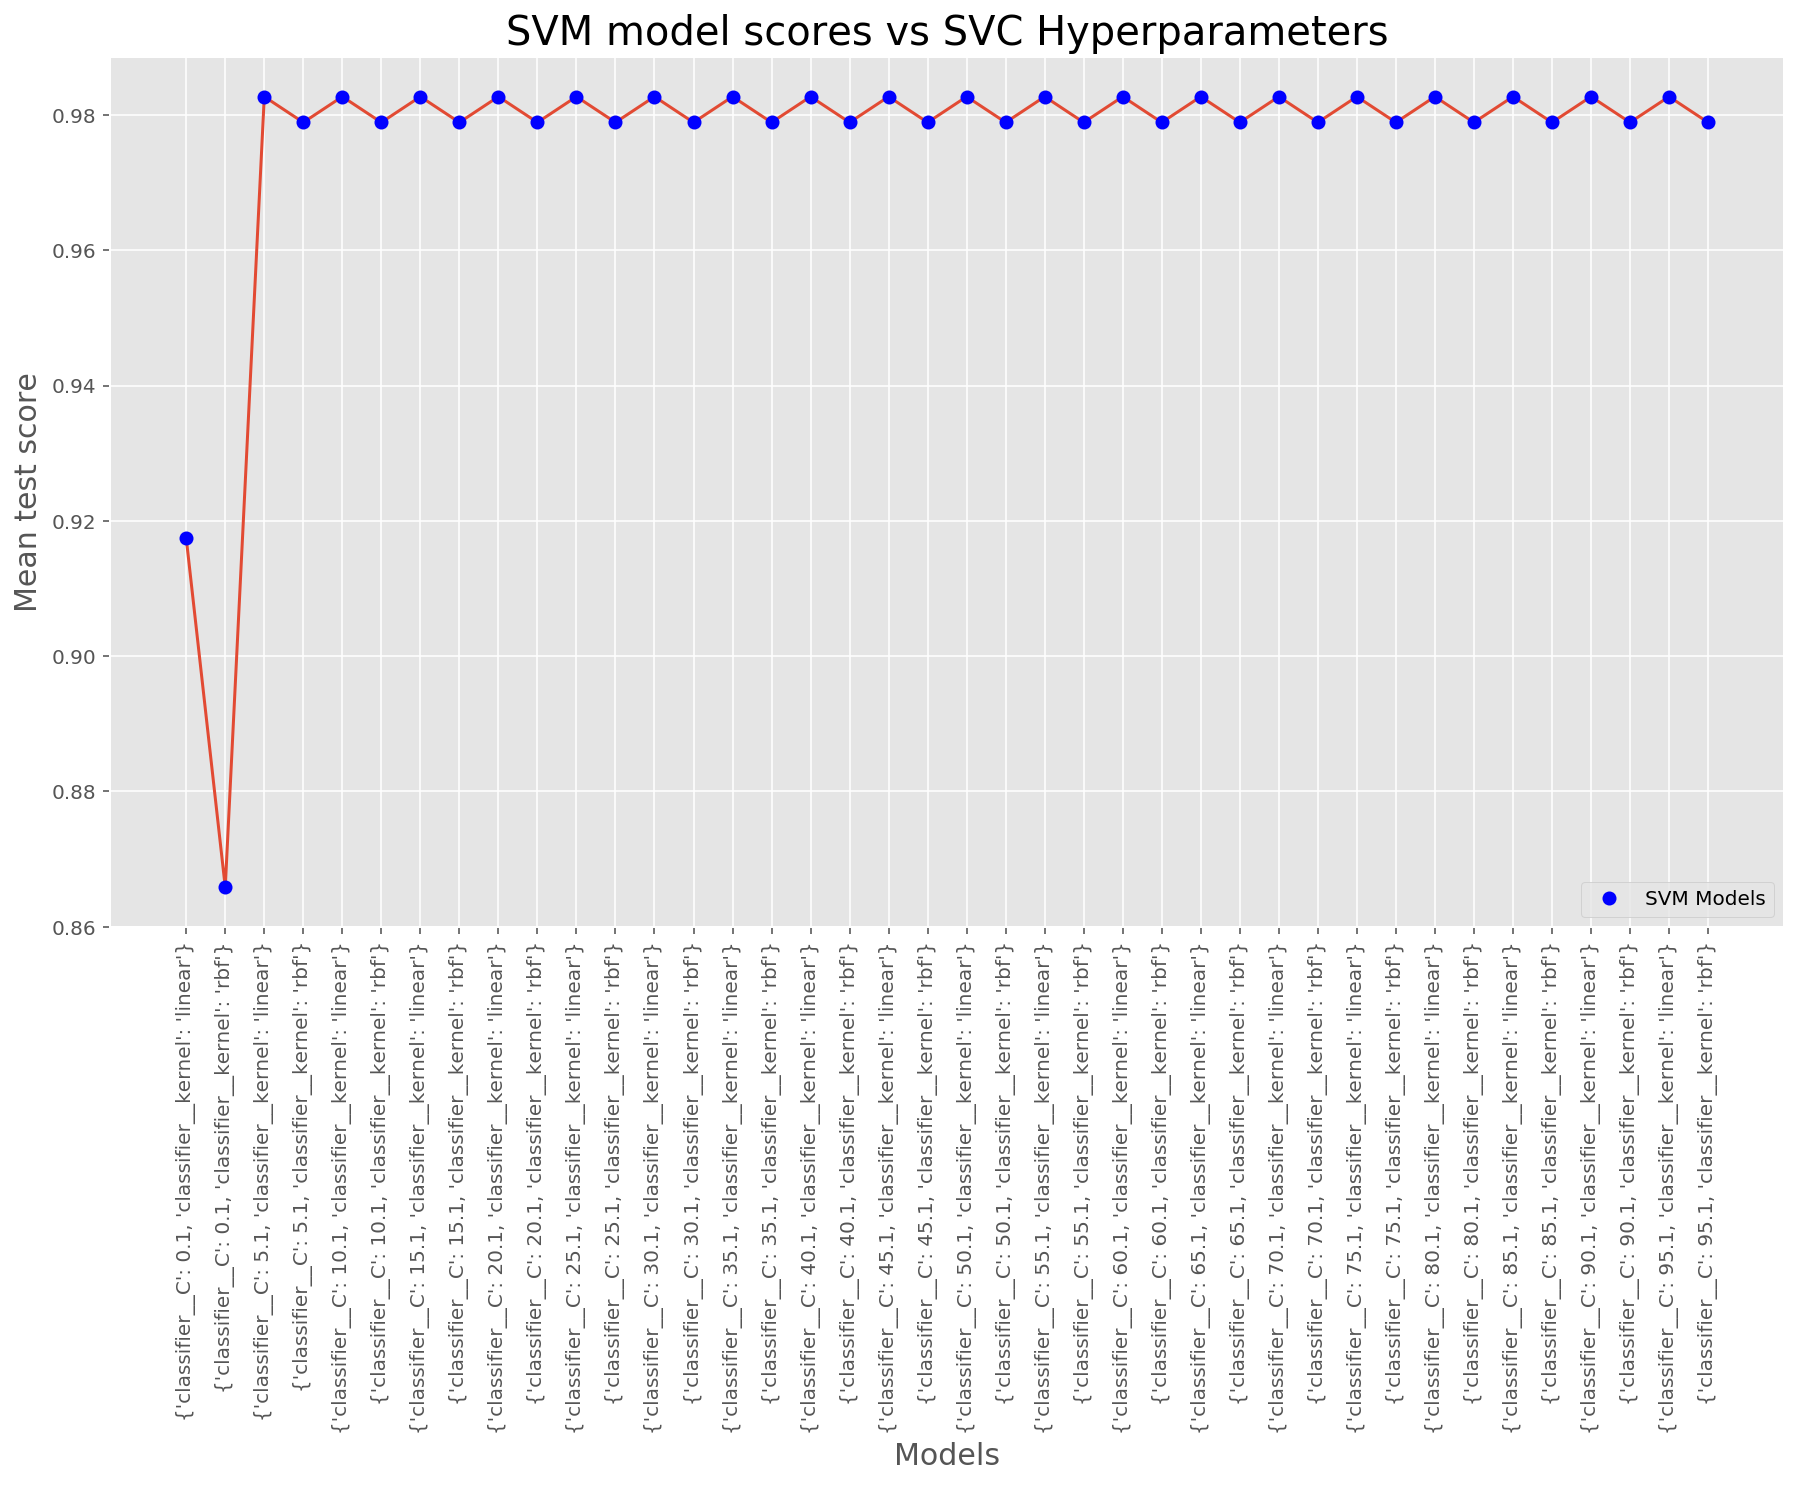

In [25]:
plt.figure(figsize = (15, 8))
plt.plot(svc_grid.cv_results_["mean_test_score"])
plt.plot(svc_grid.cv_results_["mean_test_score"], "bo", label = "SVM Models")
plt.title("SVM model scores vs SVC Hyperparameters", fontsize = 20)
plt.xlabel('Models', fontsize = 15)
plt.ylabel('Mean test score', fontsize = 15)
plt.xticks(range(0, len(svc_grid.cv_results_['params'])), svc_grid.cv_results_['params'], rotation = 90)
plt.legend()
plt.show()

We can also visualize the above plot in 3D, as we have 2 parameter arrays for X and Y axes against the accuracy.

In [20]:
results=pd.concat([pd.DataFrame(svc_grid.cv_results_["params"]),
           pd.DataFrame(svc_grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

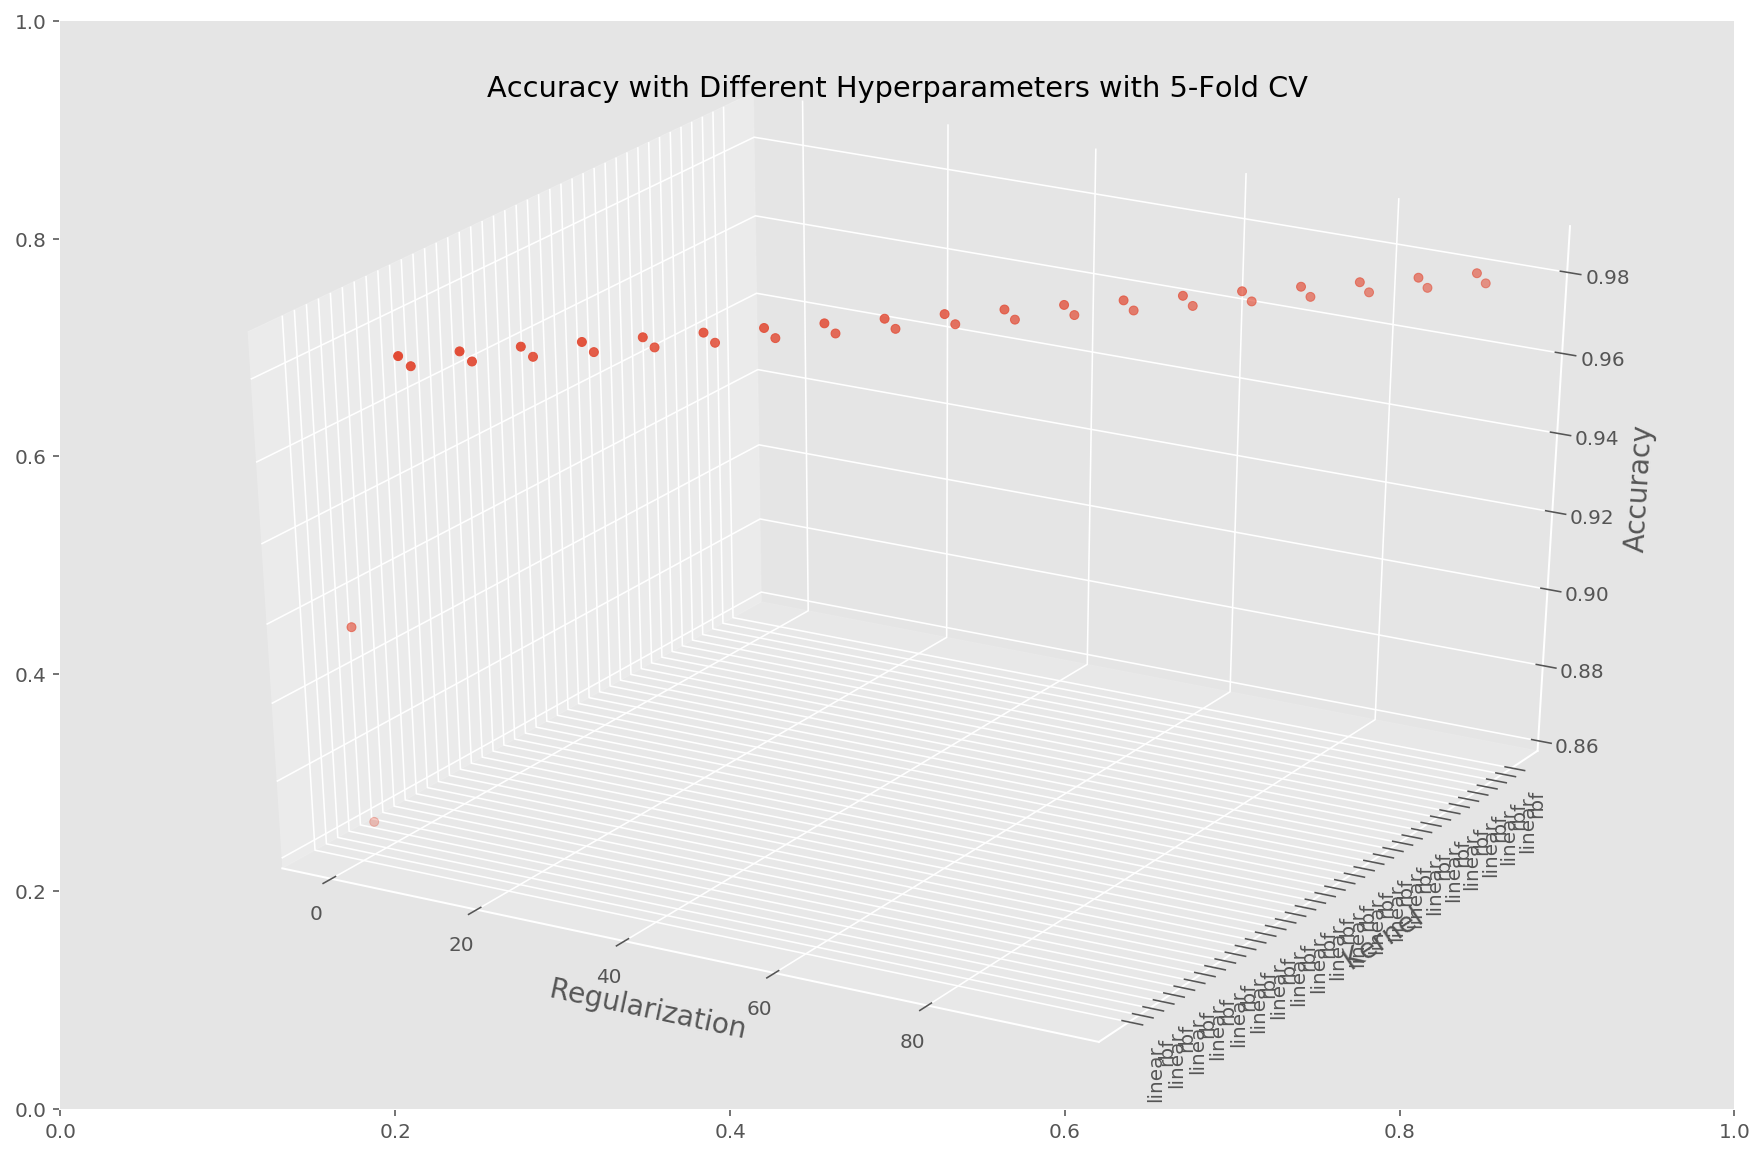

In [42]:
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results.classifier__C, range(len(results.classifier__kernel)), results.Accuracy)
ax.set_yticks(range(len(results.classifier__kernel)))
ax.set_yticklabels(results.classifier__kernel, rotation=90)
plt.title('Accuracy with Different Hyperparameters with 5-Fold CV')
ax.set_xlabel('Regularization', fontsize=14)
ax.set_ylabel('Kernel', fontsize=14)
ax.set_zlabel('Accuracy', fontsize=14)
plt.show()

In [0]:
pred = svc_grid.predict(X_test)
print('Recall:', recall_score(y_test,pred))
print('Precision:',precision_score(y_test,pred))
print('Accuracy:', accuracy_score(y_test,pred)) 
print('Log Loss:', log_loss(y_test,pred))

Recall: 0.9463087248322147
Precision: 0.9929577464788732
Accuracy: 0.9919282511210762
Log Loss: 0.27878904677276


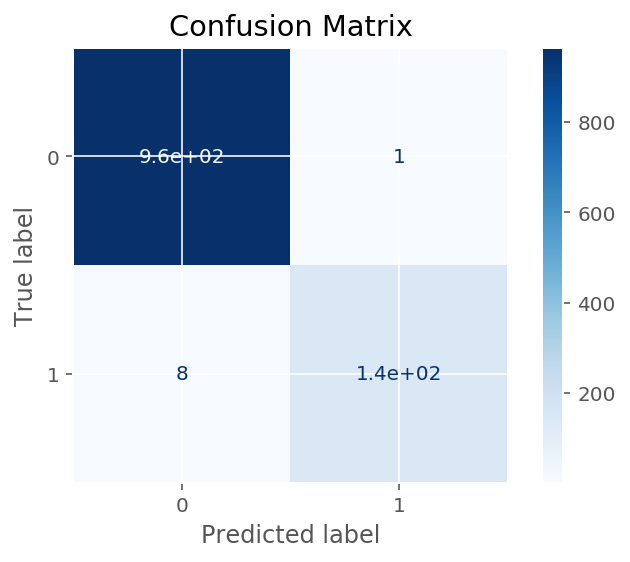

,Predicted: 0,Predicted: 1
Actual: 0,965,1
Actual: 1,8,141


In [0]:
y_hat = svc_grid.predict(X_test)
cm = confusion_matrix(y_test, y_hat)
df_cm = pd.DataFrame(data = cm, columns = ['Predicted: 0', 'Predicted: 1'], index = ['Actual: 0', 'Actual: 1'])
plot_confusion_matrix(svc_grid,X_test,y_test,cmap=plt.cm.Blues,display_labels=[0,1])
plt.title("Confusion Matrix")
plt.show()
df_cm

In [0]:
acc = accuracy_score(y_test, y_hat) 
cr=classification_report(y_test, y_hat) 

print('Accuracy score:', np.round(acc, 5))
print('\nClassification report:')
print(cr)

Accuracy score: 0.99193

Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       966
           1       0.99      0.95      0.97       149

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



We can see that the accuracy achieved is very high with >99%. More importantly, the model had a True Positive of 965 and True Negative of 141, and low False Positive of 8 and False Negative of 1, meaning it could correctly classify almost of the emails as Ham or Spam respectively. This is also shown in high F1 score, recall, and precision model. Hence using the optimal hyperparameters discovered via grid search, we have built an effective email spam classifier.

# Exercise 2: Compare SVM based spam filter with another model 

Now we reuse the SMS dataset and train it on a **Decision Tree Classifier** instead, to compare the results. The main hyperparameter chosen to be optimized is the tree depth in this case.

In [0]:
from sklearn import tree

In [0]:
#we will check the performance against the decision tree with best parameters from GridSearch
clf_dt_c_p = Pipeline([
    ("vectorizer", TfidfVectorizer(stop_words = 'english', lowercase = True)),
    ("classifier", tree.DecisionTreeClassifier())])

param_grid = [{"classifier__max_depth" :  np.arange(500, 2000, 50)}]

clf_dt_c_p_grid = GridSearchCV(clf_dt_c_p, cv = 5, n_jobs = 5, param_grid = param_grid[0], verbose = 1, refit = True)
clf_dt_c_p_grid.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    6.2s
[Parallel(n_jobs=5)]: Done 150 out of 150 | elapsed:   17.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                    

In [0]:
clf_dt_c_p_grid.best_params_

{'classifier__max_depth': 1950}

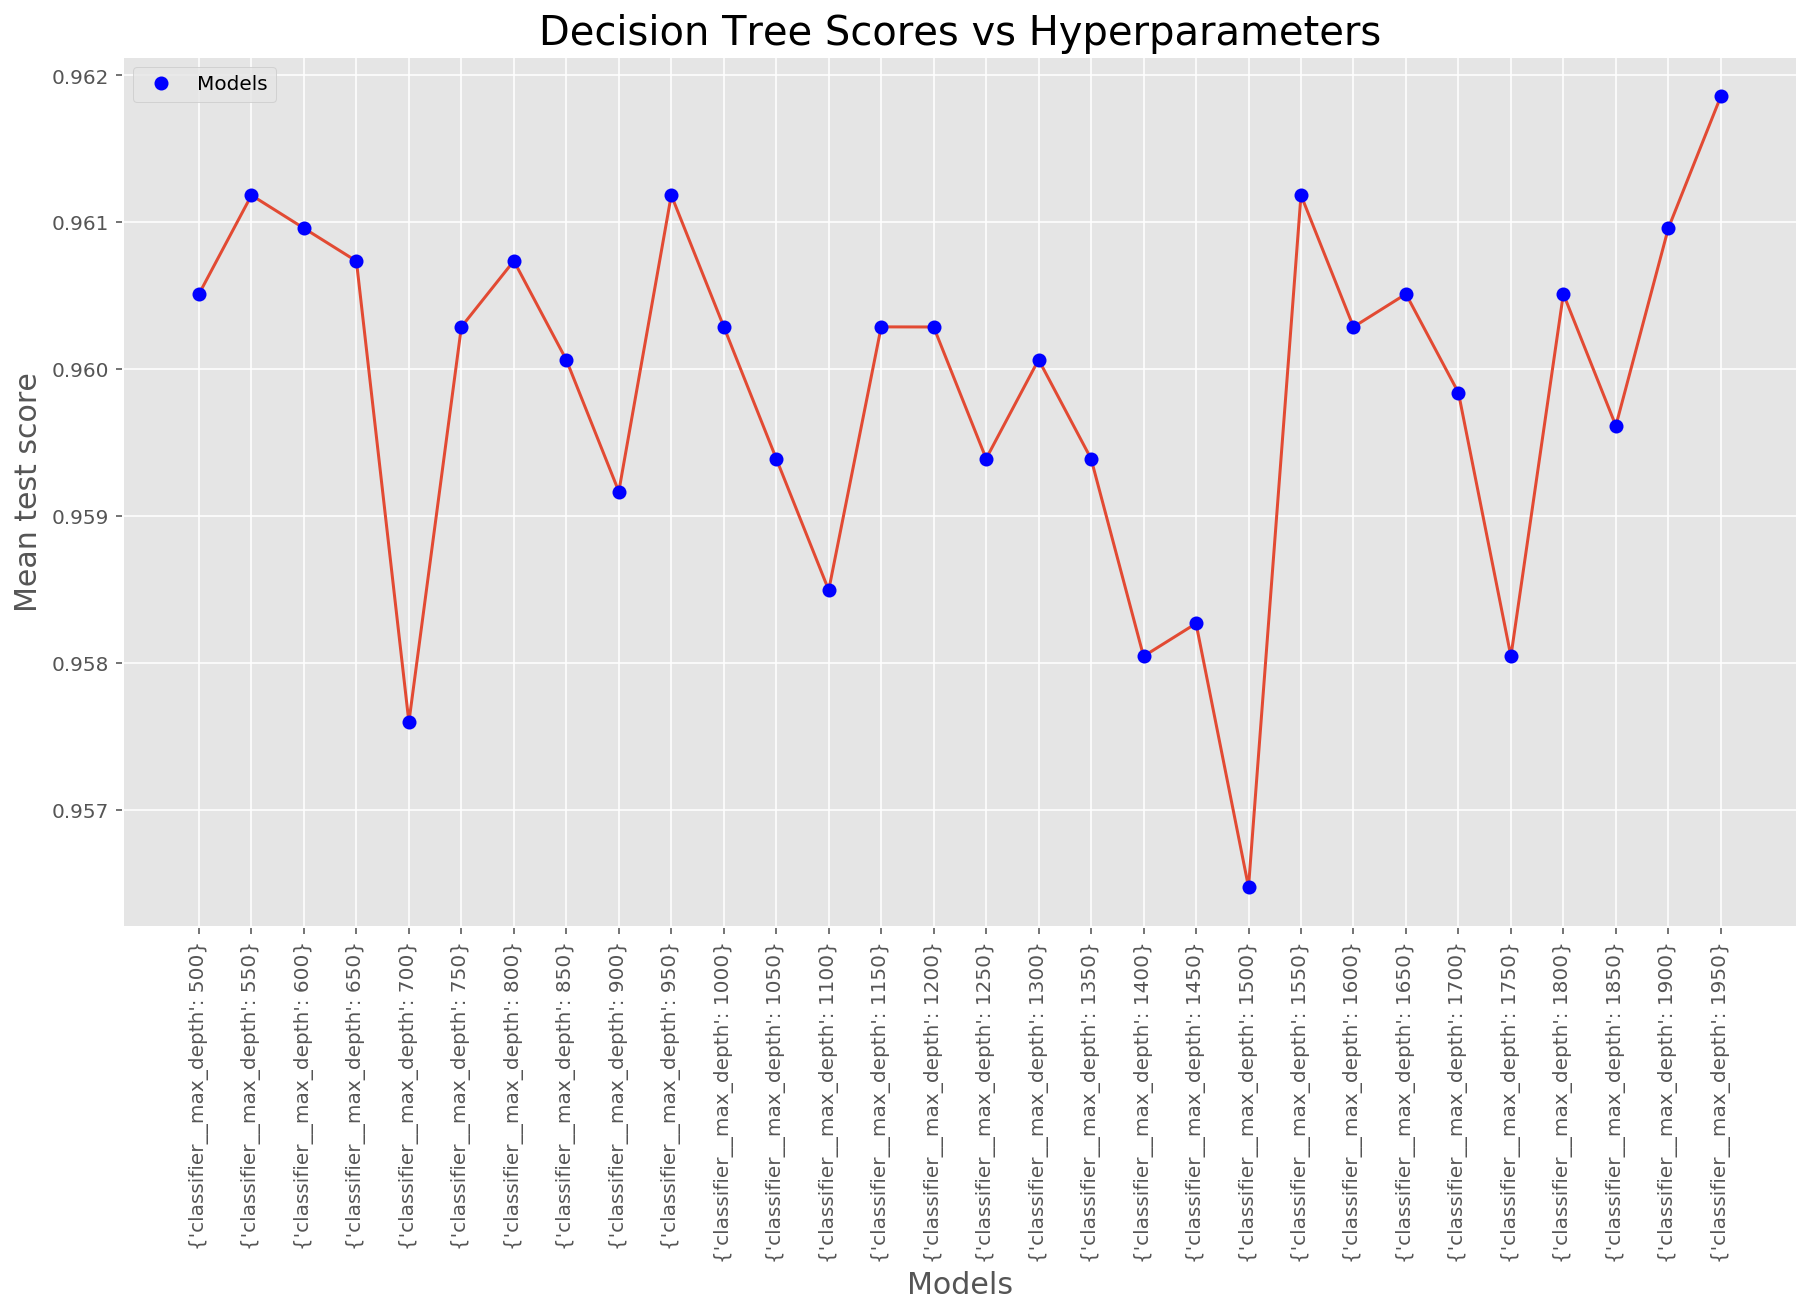

In [0]:
plt.figure(figsize = (15, 8))
plt.plot(clf_dt_c_p_grid.cv_results_["mean_test_score"])
plt.plot(clf_dt_c_p_grid.cv_results_["mean_test_score"], "bo", label = "Models")
plt.title("Decision Tree Scores vs Hyperparameters", fontsize = 20)
plt.xlabel('Models', fontsize = 15)
plt.ylabel('Mean test score', fontsize = 15)
plt.xticks(range(0, len(clf_dt_c_p_grid.cv_results_['params'])), clf_dt_c_p_grid.cv_results_['params'], rotation = 90)
plt.legend()
plt.show()

In [0]:
pred = clf_dt_c_p_grid.predict(X_test)
print('Recall',recall_score(y_test,pred))
print('Precision',precision_score(y_test,pred))
print('Accuracy',accuracy_score(y_test,pred)) 
print('Log Loss',log_loss(y_test,pred))

Recall 0.8389261744966443
Precision 0.9124087591240876
Accuracy 0.967713004484305
Log Loss 1.1151619241129576


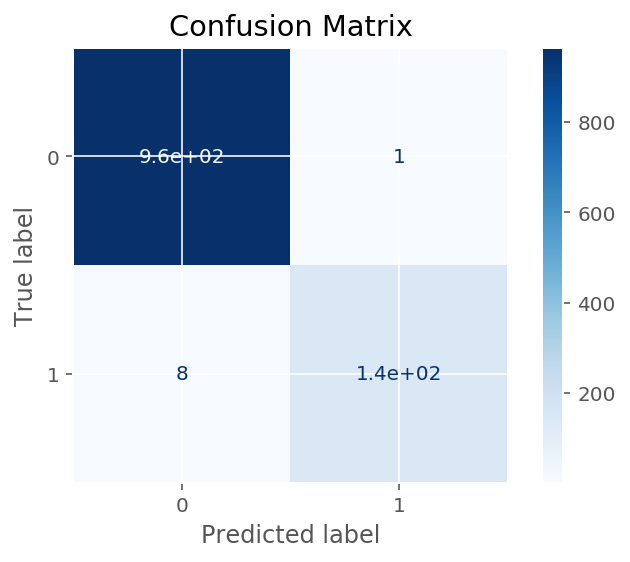

,Predicted: 0,Predicted: 1
Actual: 0,954,12
Actual: 1,24,125


In [0]:
y_hat = clf_dt_c_p_grid.predict(X_test)
cm = confusion_matrix(y_test, y_hat)
df_cm = pd.DataFrame(data = cm, columns = ['Predicted: 0', 'Predicted: 1'], index = ['Actual: 0', 'Actual: 1'])
plot_confusion_matrix(svc_grid,X_test,y_test,cmap=plt.cm.Blues,display_labels=[0,1])
plt.title("Confusion Matrix")
plt.show()
df_cm

In [0]:
acc = accuracy_score(y_test, y_hat) 
cr=classification_report(y_test, y_hat) 

print('Accuracy score:', np.round(acc, 5))
print('\nClassification report:')
print(cr)

Accuracy score: 0.96771

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       966
           1       0.91      0.84      0.87       149

    accuracy                           0.97      1115
   macro avg       0.94      0.91      0.93      1115
weighted avg       0.97      0.97      0.97      1115



While the results Decision Tree classifier are still good, they fall short of that achieved from SVM method. SVM is generally suited when there is a clear margin of separation in thise case. And also the number of dimensions is greater than the number of samples. However the training time is much longer (also we used more hyperparameters in the training phase). Also the 5-fold CV for SVM is computationally more expensive. Having said that, we could probably get better results by pruning tree, or using gradient boosting methods. Or simply go with a Random Forest model.

# References

[1] https://towardsdatascience.com/applied-text-classification-on-email-spam-filtering-part-1-1861e1a83246<br>
[2] https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html <br>
[3] https://scikit-learn.org/stable/modules/svm.html#svm <br>
[4] https://www.kaggle.com/pablovargas/naive-bayes-svm-spam-filtering <br>
[5] https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection <br>
[6] https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html <br>
[7] https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976 <br>

